In [1263]:
import reservoirpy as rpy

rpy.verbosity(0)
# rpy.set_seed(500)

0

#### Prepare input data

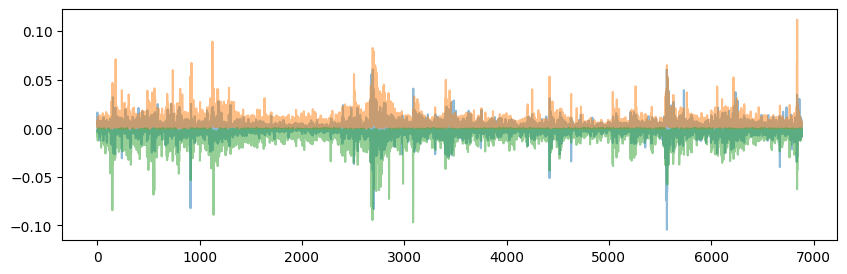

In [1264]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("spy-ohlc.csv", delimiter=",", skiprows=1, usecols=(1, 2, 3, 4, 5))

OPEN = 0
HIGH = 1
LOW = 2
CLOSE = 3
VOLUME = 4

close_to_open = (data[1:, OPEN] - data[:-1, CLOSE]) / data[:-1, CLOSE]

open_to_high = ((data[:, HIGH] - data[:, OPEN]) / data[:, OPEN])[1:]

open_to_low = ((data[:, LOW] - data[:, OPEN]) / data[:, OPEN])[1:]

close = ((data[:, CLOSE] - data[:, OPEN]) / data[:, OPEN])[1:]
mask = close > 0
close[mask] = close[mask] / open_to_high[mask]
mask = close < 0
close[mask] = -(close[mask] / open_to_low[mask])

volume = (data[1:, VOLUME] - data[1:, VOLUME].mean()) / data[1:, VOLUME].std()

x = np.concatenate(
    (
        close_to_open.reshape(-1, 1),
        open_to_high.reshape(-1, 1),
        open_to_low.reshape(-1, 1),
        close.reshape(-1, 1),
        volume.reshape(-1, 1),
    ),
    axis=1,
)

plt.figure(figsize=(10, 3))
plt.plot(x[:, :-2], alpha=0.5)
plt.show()

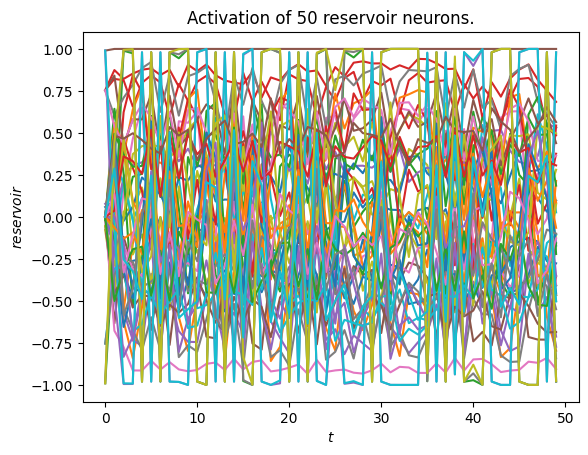

In [1265]:
from reservoirpy.nodes import Reservoir

reservoir = Reservoir(
    5000,
    lr=0.99,
    sr=0.9,
    activation=rpy.activationsfunc.tanh,
    input_scaling=10,
    fb_connectivity=0.1,
    input_connectivity=0.1,
)
states = reservoir.run(x[:50], reset=True)

plt.title("Activation of 50 reservoir neurons.")
plt.ylabel("$reservoir$")
plt.xlabel("$t$")
plt.plot(states[:, :50])
plt.show()

In [1266]:
from reservoirpy.nodes import Ridge

readout = Ridge(ridge=1e-7)

x_train = x[-5002:-2, :]
y_train = x[-5001:-1, :]

In [ ]:
train_states = reservoir.run(x_train, reset=True)

readout = readout.fit(train_states, y_train, warmup=100)

test_states = reservoir.run(x[-5001:-1, :])
y_pred = readout.run(test_states)

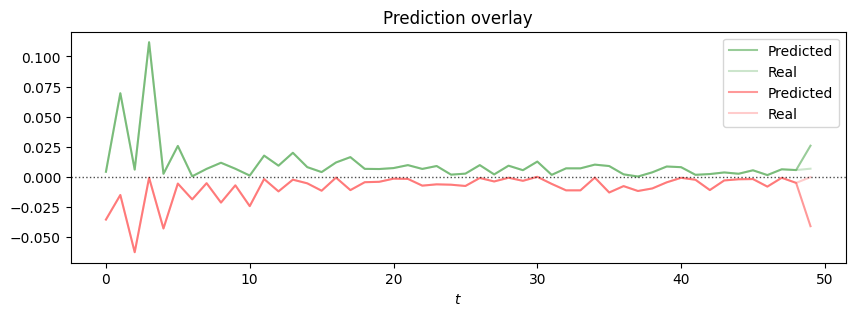

In [1268]:
plt.figure(figsize=(10, 3))
plt.title("Prediction overlay")
plt.xlabel("$t$")
plt.plot(y_pred[-50:, HIGH], label="Predicted", color="green", alpha=0.4)
plt.plot(x[-50:, HIGH], label="Real", color="green", alpha=0.2)
plt.plot(y_pred[-50:, LOW], label="Predicted", color="red", alpha=0.4)
plt.plot(x[-50:, LOW], label="Real", color="red", alpha=0.2)
plt.axhline(0, color="black", linestyle=":", linewidth=1, alpha=0.7)
plt.legend()
plt.show()

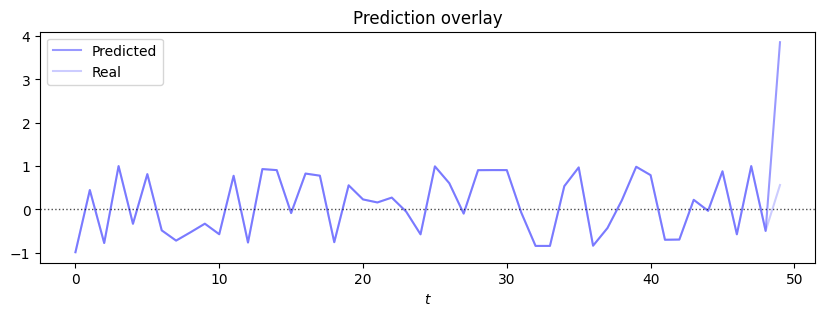

In [1269]:
plt.figure(figsize=(10, 3))
plt.title("Prediction overlay")
plt.xlabel("$t$")
plt.plot(y_pred[-50:, CLOSE], label="Predicted", color="blue", alpha=0.4)
plt.plot(x[-50:, CLOSE], label="Real", color="blue", alpha=0.2)
plt.axhline(0, color="black", linestyle=":", linewidth=1, alpha=0.7)
plt.legend()
plt.show()

In [ ]:
x_prime = x[1:, CLOSE]
y_prime = y_pred[:-1, CLOSE]
mask = x_prime[1000:] < 0
X_mask = x_prime[1000:].copy()
Y_mask = y_prime[1000:].copy()
X_mask[mask] = 0
Y_mask[mask] = 0
error = abs((Y_mask - X_mask))
print(f"mean_error={error[X_mask > 0].mean()}")
print(f" std_error={error[X_mask > 0].std()}")
print(f"false_negatives={(y_prime[1000:][x_prime[1000:] > 0] < 0).sum()} of {(x_prime[1000:] > 0).sum()}")
print(f"false_positives={(y_prime[1000:][mask] > 0).sum()} of {mask.sum()}")

plt.figure(figsize=(10, 3))
plt.title("Error")
plt.xlabel("$t$")
# plt.plot(error[-1000:], label="Error", linestyle="--", color="black", alpha=0.3)
plt.plot(Y_mask, label="Predicted", color="blue", alpha=0.3)
plt.plot(X_mask, label="Real", color="red", alpha=0.3)
plt.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.7)
plt.legend()
plt.show()


IndexError: boolean index did not match indexed array along axis 0; size of axis is 3999 but size of corresponding boolean axis is 5886

: 